In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd

# Carregar dataframe salvo em formato pickle
df = pd.read_pickle("ge_df.pkl")

In [2]:
df.head()

,Texto,label
0,"[poder, decidir, expulsar, deputado, federal, ...",1
1,"[bolsonaro, liberal, completo, presidente, psl...",1
2,"[ministro, stf, liberar, Andrea, Neves, prisao...",1
3,"[apesar, abundancia, crescer, preocupacao, pre...",1
4,"[harvard, mit, levarao, dilma, moro, suplicy, ...",1


In [3]:
# Converte a coluna 'Texto' do DataFrame em uma lista e armazena na variável texts. O mesmo com as labels
texts = df['Texto'].tolist()
labels = df['label'].tolist()  # Rótulos das notícias

In [4]:
# Tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

In [5]:

#word_index é um dicionário onde as chaves são as palavras e os valores são os índices dessas palavras.
#Esse índice é útil para várias tarefas de NLP, como a criação de embeddings de palavras ou a preparação de dados para modelos de deep learning.
word_index

{'nao': 1,
 '“': 2,
 '”': 3,
 'ano': 4,
 'dizer': 5,
 'ser': 6,
 'lula': 7,
 'tambem': 8,
 'sao': 9,
 'presidente': 10,
 'ter': 11,
 'federal': 12,
 'ja': 13,
 'governo': 14,
 'afirmar': 15,
 'dia': 16,
 'r': 17,
 'pessoa': 18,
 'brasil': 19,
 'temer': 20,
 'pai': 21,
 'ate': 22,
 'caso': 23,
 'ha': 24,
 'expresidente': 25,
 'ministro': 26,
 '–': 27,
 'haver': 28,
 'fazer': 29,
 'politico': 30,
 'publico': 31,
 'ficar': 32,
 'empresa': 33,
 'processo': 34,
 'acordo': 35,
 'milhoes': 36,
 'policia': 37,
 'receber': 38,
 'justica': 39,
 'jato': 40,
 'dilma': 41,
 'defesa': 42,
 'paulo': 43,
 'falar': 44,
 'deputado': 45,
 'so': 46,
 'ministerio': 47,
 'passar': 48,
 'voce': 49,
 'estao': 50,
 'dinheiro': 51,
 'pedir': 52,
 'brasileiro': 53,
 'chegar': 54,
 'crime': 55,
 'casa': 56,
 'estar': 57,
 'durante': 58,
 'poder': 59,
 'hoje': 60,
 'rio': 61,
 'apos': 62,
 'juiz': 63,
 'tribunal': 64,
 'publicar': 65,
 'operacao': 66,
 'odebrecht': 67,
 'deixar': 68,
 'decisao': 69,
 'alem': 70,
 

In [6]:
import pickle

# Salva o tokenizador em um arquivo (precisamos dele mais tarde, quando realizarmos as inferências)
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [7]:
import numpy as np

# Calcula o comprimento de cada sequência em 'sequences' e armazena os resultados na lista 'sequence_lengths'
sequence_lengths = [len(seq) for seq in sequences]

# Calcula a média dos comprimentos das sequências usando a função 'mean' do numpy
mean_length = np.mean(sequence_lengths)

# Obtém o comprimento máximo das sequências usando a função 'max' do Python
max_length = max(sequence_lengths)

# Imprime a média e o comprimento máximo das sequências
print("Mean sequence length: ", mean_length)
print("Maximum sequence length: ", max_length)

Mean sequence length:  340.45117377413527
Maximum sequence length:  3835


In [8]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Calcula o percentil 95 dos comprimentos das sequências (preserva 95% das sequências)
max_length = int(np.percentile(sequence_lengths, 95))

# Realiza o preenchimento das sequências com base no novo 'max_length'
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [9]:
# Carrega os embeddings do GLoVe
embeddings_index = {}
with open('glove.6B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [10]:
# Preparar a matriz de embedding
embedding_dim = 200  # o tamanho do seu GLoVe embeddings
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [11]:
# One-hot encoding dos rótulos
num_classes = len(np.unique(labels))  # Número de classes únicas
labels = to_categorical(labels, num_classes=num_classes)

In [12]:
from sklearn.model_selection import train_test_split

# Divida os dados em um conjunto de treino (70%) e um conjunto temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3)

# Divida o conjunto temporário em conjuntos de validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)  # 0.5 * 0.3 = 0.15

In [13]:
# Construindo o modelo
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(num_classes, activation='softmax'))  # Camada de saída para classificação multiclasse

# Chamada ao Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(X_train, y_train, batch_size=128, epochs=40, validation_data=(X_val, y_val), callbacks=[early_stopping])
     

Epoch 1/40
40/40 [==============================] - 31s 565ms/step - loss: 0.6802 - accuracy: 0.6239 - val_loss: 0.5422 - val_accuracy: 0.7167
Epoch 2/40
40/40 [==============================] - 20s 504ms/step - loss: 0.4611 - accuracy: 0.7879 - val_loss: 0.4144 - val_accuracy: 0.8130
Epoch 3/40
40/40 [==============================] - 22s 557ms/step - loss: 0.4197 - accuracy: 0.8188 - val_loss: 0.4877 - val_accuracy: 0.7444
Epoch 4/40
40/40 [==============================] - 22s 541ms/step - loss: 0.3717 - accuracy: 0.8430 - val_loss: 0.3432 - val_accuracy: 0.8630
Epoch 5/40
40/40 [==============================] - 21s 532ms/step - loss: 0.3055 - accuracy: 0.8877 - val_loss: 0.3299 - val_accuracy: 0.8546
Epoch 6/40
40/40 [==============================] - 22s 541ms/step - loss: 0.3432 - accuracy: 0.8793 - val_loss: 0.2386 - val_accuracy: 0.9324
Epoch 7/40
40/40 [==============================] - 21s 533ms/step - loss: 0.1735 - accuracy: 0.9464 - val_loss: 0.2230 - val_accuracy: 0.9241

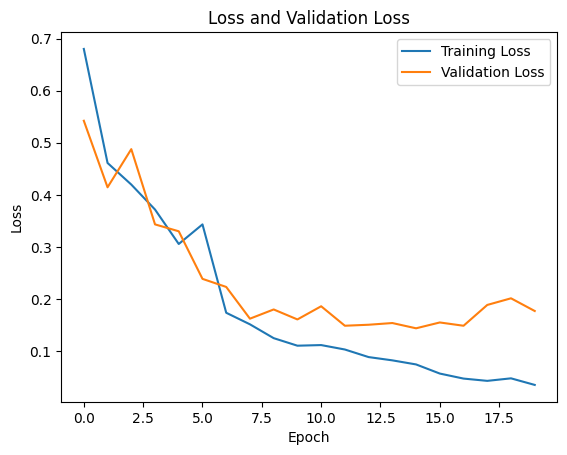

In [14]:
import matplotlib.pyplot as plt

# Plota a perda (loss) e a perda de validação (val_loss) durante o treinamento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Salva arquivos em discos que podemos carregar sem treinar a rede neural novamente
model.save('ge_BiLSTM_glove6b200d.h5')
np.save("X_test_BiLSTM_glove6b200d.npy", X_test)
np.save("y_test_BiLSTM_glove6b200d.npy", y_test)

In [16]:
from tensorflow.keras.models import load_model
import numpy as np

# Carrega arquivos pertinentes ao treinamento da rede neural e X_test e y_test (usados na avaliação de resultados)
model = load_model('ge_BiLSTM_glove6b200d.h5')
X_test = np.load("X_test_BiLSTM_glove6b200d.npy")
y_test = np.load("y_test_BiLSTM_glove6b200d.npy")

with open('tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

In [17]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Acurácia final:', accuracy)

34/34 [==============================] - 7s 163ms/step - loss: 0.1682 - accuracy: 0.9491
Acurácia final: 0.9490740895271301


In [18]:
# Fazer as previsões do modelo para o conjunto de teste
y_pred = model.predict(X_test)

34/34 [==============================] - 7s 159ms/step


In [19]:
#Transformar as previsões de volta em rótulos
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

conf_mat

array([[495,  36],
       [ 19, 530]], dtype=int64)

In [20]:
import pandas as pd

# Lê o arquivo .csv
df = pd.read_pickle("ge_df.pkl")

# Total de classes
classes = df['label'].nunique()

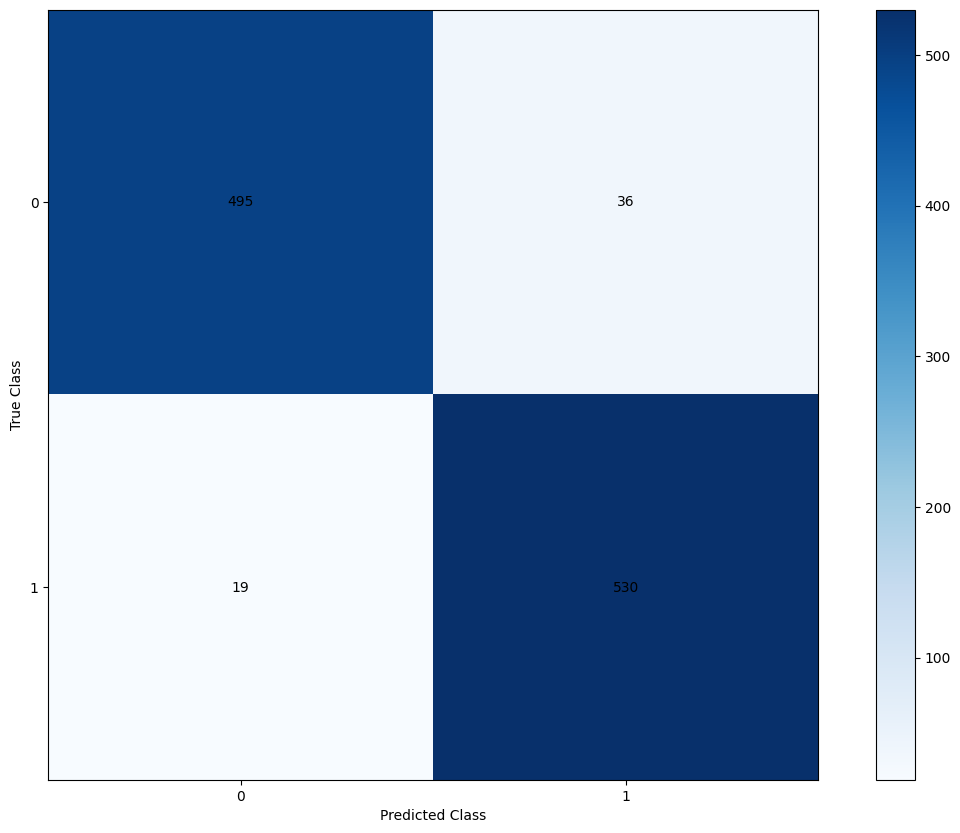

In [21]:
import matplotlib.pyplot as plt

# Define o tamanho da figura
plt.figure(figsize=(15, 10))

# Define mapa de cores
cmap = plt.cm.Blues

# Plota matriz de confusão
plt.imshow(conf_mat, cmap=cmap)
plt.colorbar()

# Adiciona rótulos a matriz
plt.xticks([int(i) for i in range(2)], [str(i) for i in range(2)])
plt.yticks([int(i) for i in range(2)], [str(i) for i in range(2)])

for i in range(classes):
    for j in range(classes):
        plt.text(j, i, str(conf_mat[i, j]), ha='center', va='center', color='white' if conf_mat[i, j] > len(y_true_labels)/ classes else 'black')

# Adiciona rótulos dos eixos
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Mostra o plot
plt.show()

In [22]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcula precisão, recall e f1-score para cada classe
precisions = []
recalls = []
f1_scores = []
for i in range(classes):
    precision = precision_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    recall = recall_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    f1 = f1_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Printa resultados
for i in range(classes):
    print(f"Class '{i}': Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1-Score={f1_scores[i]:.4f}")

# Calcula e printa a média dos f1-scores
f1_average = np.mean(f1_scores)
print(f"Average F1-Score: {f1_average:.4f}")

Class '0': Precision=0.9630, Recall=0.9322, F1-Score=0.9474
Class '1': Precision=0.9364, Recall=0.9654, F1-Score=0.9507
Average F1-Score: 0.9490


In [23]:
import string
import spacy
import unicodedata
from tqdm import tqdm
import numpy as np

# Habilita suporte do tqdm para os métodos de progressão do pandas (como progress_aplly)
tqdm.pandas()

# Carrega modelo de linguagem 'pt_core_news_lg' do spacy para processamento de texto em português
# Desabilita os componentes 'parser' e 'ner', já que não são necessários para a lematização
spacy_nlp_model = spacy.load("pt_core_news_lg", disable=["parser", "ner"])

def preprocess_data(df, text_column):
    """
    Realiza o pré-processamento dos dados de um texto em um Dataframe do Pandas.
    Remove pontuação, números e palavras comuns (stop words), converte para minúsculas, remove 
    acentos e símbolos diversos, e aplica lematização.
    """

    # Cria tabela de tradução que mapeia cada caractere de pontuação do módulo 'string.ponctuation'
    # para 'None' (ou seja, remove-os do texto).
    print("Removendo pontuação...")
    translator = str.maketrans('', '', string.punctuation)
    df[text_column] = df[text_column].progress_apply(lambda x: x.translate(translator))

    print("Removendo números...")
    translator = str.maketrans('', '', string.digits)
    df[text_column] = df[text_column].progress_apply(lambda x: x.translate(translator))

    print("Removendo acentos e símbolos diversos...")
    def remove_accents_and_symbols(text):
        try:
            # Normaliza a string para a forma NFKD e mantém apenas caracteres que não são diacríticos
            # nem combinam caracteres com diacríticos
            return ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c) and unicodedata.category(c) != 'Mn')
        except TypeError:
            # Se não for possível normalizar um caractere, retorna uma string vazia
            return ''
        # Aplica a função 'remove_accents_and_symbols' na coluna 'text_column'
    df[text_column] = df[text_column].progress_apply(lambda x: remove_accents_and_symbols(x))
    
    print("Convertendo para minúsculas...")
    df[text_column] = df[text_column].progress_apply(lambda x: x.lower())

    print("Computando Lematização...")
    def lemmatize_text(doc):
        return [token.lemma_ for token in doc if not token.is_stop]

    n_chunks = 10  # Ajuste esse valor de acordo com o tamanho da base de dados e a memória disponível no sistema
    chunks = np.array_split(df, n_chunks) # Divide o dataframe em várias partes

    processed_chunks = []
    for i, chunk in enumerate(chunks):
        print(f"Processando segmento {i + 1} de {n_chunks}")
        processed_chunk = chunk.copy() # Cria uma cópia para realizar o processamento
        
        #  Aplica a função 'lemmatize_text' a cada documento processado pelo spaCy (usando 'spacy_nlp_model.pipe') e
        # atribui os resultados (uma lista de palavras lematizadas) à coluna 'text_column' do DataFrame 'processed_chunk'.
        # O tqdm é utilizado para exibir uma barra de progresso durante o processamento dos documentos.
        processed_chunk[text_column] = [lemmatize_text(doc) for doc in tqdm(spacy_nlp_model.pipe(chunk[text_column].astype(str), batch_size=100, disable=['parser', 'ner']), total=len(chunk[text_column]))]

        # Junta as partes em uma lista, para formar o dataframe final
        processed_chunks.append(processed_chunk)

    concatenated_df = pd.concat(processed_chunks) # Concatenar os DataFrames processados
    df[text_column] = concatenated_df[text_column] # Atribuir a coluna 'data' processada de volta ao dataframe original
    
    print("Remover tokens com espaços vazios...")
    df['Texto'] = df['Texto'].progress_apply(lambda x: [token for token in x if token.strip()])

In [24]:
from gensim.models import Word2Vec

# Carrega o modelo Word2Vec para um arquivo
word2vec_model = Word2Vec.load("word2vec_model.model")

In [25]:
# Cria dois dicionários para mapear as palavras aos seus respectivos índices e vice-versa.
# Isso é feito para facilitar a conversão entre palavras e índices durante a criação de sequências
# numéricas que representam os textos. Essas sequências numéricas serão usadas como entrada para
# modelos de aprendizado de máquina, como redes neurais.
# Exemplo: 
# Suponha que o vocabulário seja ['casa', 'carro', 'jardim'], então os dicionários serão:
# word_to_index = {'casa': 1, 'carro': 2, 'jardim': 3}
# index_to_word = {1: 'casa', 2: 'carro', 3: 'jardim'}

# 'word_to_index' é um dicionário que mapeia cada palavra ao seu índice correspondente.
word_to_index = {}

# 'index_to_word' é um dicionário que mapeia cada índice à palavra correspondente.
index_to_word = {}

# Itera sobre a lista de palavras únicas obtida do modelo Word2Vec
for i, word in enumerate(word2vec_model.wv.index_to_key):
    # Atribui a palavra ao índice i + 1 no dicionário 'word_to_index'.
    # Os índices começam em 1 para reservar o índice 0 para preenchimento (padding) quando necessário.
    word_to_index[word] = i + 1
    
    # Atribui o índice i + 1 à palavra no dicionário 'index_to_word'.
    index_to_word[i + 1] = word

In [26]:
# Criei um dataframe simples com uma notícia só para aplicarmos a função preprocess_data

import pandas as pd
from nltk.tokenize import word_tokenize

value = """Depoimento de Cid incluiu golpe, vacina, joias e Abin

Ex-ajudante de ordens manteve versão de que não pode afirmar que Bolsonaro planejou um golpe; PF avalia ter fechado “pontos em aberto”

Em depoimento de mais de oito horas, o ex-ajudante de ordens de Jair Bolsonaro (PL) Mauro Cid foi questionado pela Polícia Federal (PF) sobre as investigações do plano golpista, do escândalo das joias, do registro falso de vacina e da “Abin paralela”.

A oitiva, nas palavras de agentes da PF, teve como objetivo fechar pontos que estavam ambíguos ou abertos de oitivas anteriores do militar da ativa.
Na avaliação de investigadores, o longo depoimento serviu para “fechar os pontos que estavam em aberto” da investigação.

Segundo agentes da investigação, Cid foi perguntado se tinha conhecimento de que o ex-presidente Jair Bolsonaro planejava um plano para se manter no poder.

O militar, porém, manteve a versão anterior, de acordo com integrantes da PF: de que foi discutida uma minuta de decretação de estado de defesa, mas que não pode afirmar que o então presidente planejava um golpe.
À PF, Cid disse que o ex-presidente se reuniu com generais após perder as eleições de outubro de 2022, mas negou ter participado do encontro em que o alto escalão das Forças Armadas teria debatido os termos da minuta de um golpe de Estado.

Segundo apurou a CNN, Cid também confirmou que Freire Gomes era contra a decretação de um estado de defesa, presente na chamada “minuta do golpe”.

O depoimento do militar corroborou outros já colhidos pela PF, como do ex-comandante do Exército, general Freire Gomes, e do ex-comandante da Aeronáutica, brigadeiro Carlos Baptista Junior.

A expectativa é de que Cid seja chamado novamente para depor nos próximos meses. Antes, a PF deve mandar comitiva aos Estados Unidos para tentar obter imagens e documentos na investigação do escândalo das joias.

Segundo relatos de investigadores, o depoimento de Cid foi satisfatório, e que o acordo de colaboração não está ameaçado, mas não se encerra colaboração de Cid nas investigações da PF. Ele é obrigado a colaborar até o fim do inquérito.
"""

# Crie um DataFrame com uma linha e a coluna 'data'
df_predict = pd.DataFrame(data={'Texto': [value]})

# Faz pré-processamento
preprocess_data(df_predict, 'Texto')

# Conversão dos dados para serem usados no modelo (rede neural)
preprocessed_articles = df_predict['Texto'].tolist()

sequences_test = []
for tokens in tqdm(preprocessed_articles):
    sequence = []
    for token in tokens:
        if token in word_to_index:
            sequence.append(word_to_index[token])
    sequences_test.append(sequence)
    
padded_example = pad_sequences(sequences_test, maxlen=max_length, padding='post')

# Fazer a previsão usando o modelo
predictions = model.predict(padded_example)

Removendo pontuação...


100%|██████████| 1/1 [00:00<00:00, 981.12it/s]


Removendo números...


100%|██████████| 1/1 [00:00<00:00, 1022.00it/s]


Removendo acentos e símbolos diversos...


100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


Convertendo para minúsculas...


100%|██████████| 1/1 [00:00<?, ?it/s]
c:\Users\mathe\OneDrive\Área de Trabalho\TCC\Detector-de-Fake-News\.venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Computando Lematização...
Processando segmento 1 de 10


100%|██████████| 1/1 [00:00<00:00, 25.62it/s]


Processando segmento 2 de 10


0it [00:00, ?it/s]


Processando segmento 3 de 10


0it [00:00, ?it/s]


Processando segmento 4 de 10


0it [00:00, ?it/s]


Processando segmento 5 de 10


0it [00:00, ?it/s]


Processando segmento 6 de 10


0it [00:00, ?it/s]


Processando segmento 7 de 10


0it [00:00, ?it/s]


Processando segmento 8 de 10


0it [00:00, ?it/s]


Processando segmento 9 de 10


0it [00:00, ?it/s]


Processando segmento 10 de 10


0it [00:00, ?it/s]


Remover tokens com espaços vazios...


100%|██████████| 1/1 [00:00<?, ?it/s]


1/1 [==============================] - 0s 204ms/step


In [27]:
predictions

array([[0.00170669, 0.99829334]], dtype=float32)

In [28]:
# Identificar a classe com a maior probabilidade
predicted_class = np.argmax(predictions)

# Exibir a classe prevista
print(f"Classe prevista: {predicted_class}")

Classe prevista: 1


In [29]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import os

# Get the current working directory
notebook_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.split(notebook_dir)

caminho_csv = os.path.join(parent_dir[0], "noticias_pre_processadas.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(caminho_csv)


# Cria um objeto LabelEncoder
le = LabelEncoder()

# Transforma os rótulos para variáveis categóricas
df['label'] = le.fit_transform(df['Categoria'])

original_class = le.inverse_transform([predicted_class]) # Transforma a classe predita de variável categórica para o nome do clube, de volta
print(f"Classe original: {original_class[0]}")

Classe original: true


In [30]:
# Criei um dataframe simples com uma notícia falsa só para aplicarmos a função preprocess_data

import pandas as pd
from nltk.tokenize import word_tokenize

value = """
"Estudo Inovador Afirma que Ficar de Pijama o Dia Todo Aumenta a Produtividade"

Uma pesquisa recente realizada por uma equipe de psicólogos da Universidade de Bem-Estar Mental revelou uma descoberta surpreendente: ficar de pijama durante o dia pode aumentar significativamente a produtividade.

Segundo os pesquisadores, vestir pijamas cria uma sensação de conforto e relaxamento, o que reduz os níveis de estresse e ansiedade. Isso, por sua vez, permite que as pessoas se concentrem mais em suas tarefas e sejam mais eficientes em seu trabalho.

O estudo, que acompanhou mais de mil participantes ao longo de seis meses, descobriu que aqueles que adotaram a prática de trabalhar de pijama relataram uma melhoria notável em sua capacidade de concentração e tomada de decisões. Além disso, muitos participantes relataram sentir-se mais motivados e criativos em suas atividades diárias.

Essa descoberta desafia a noção convencional de que vestir roupas formais é essencial para o sucesso profissional. Os pesquisadores agora estão explorando maneiras de integrar essa prática inovadora em ambientes de trabalho tradicionais, potencialmente revolucionando a cultura corporativa.

Portanto, se você está procurando aumentar sua produtividade, talvez seja hora de abandonar o terno e adotar o conforto do pijama durante o expediente!
"""

# Crie um DataFrame com uma linha e a coluna 'data'
df_predict = pd.DataFrame(data={'Texto': [value]})

# Faz pré-processamento
preprocess_data(df_predict, 'Texto')

# Conversão dos dados para serem usados no modelo (rede neural)
preprocessed_articles = df_predict['Texto'].tolist()

sequences_test = []
for tokens in tqdm(preprocessed_articles):
    sequence = []
    for token in tokens:
        if token in word_to_index:
            sequence.append(word_to_index[token])
    sequences_test.append(sequence)
    
padded_example = pad_sequences(sequences_test, maxlen=max_length, padding='post')

# Fazer a previsão usando o modelo
predictions = model.predict(padded_example)

Removendo pontuação...


100%|██████████| 1/1 [00:00<00:00, 998.17it/s]


Removendo números...


100%|██████████| 1/1 [00:00<00:00, 1019.77it/s]


Removendo acentos e símbolos diversos...


100%|██████████| 1/1 [00:00<00:00, 1023.00it/s]


Convertendo para minúsculas...


100%|██████████| 1/1 [00:00<00:00, 998.88it/s]
c:\Users\mathe\OneDrive\Área de Trabalho\TCC\Detector-de-Fake-News\.venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Computando Lematização...
Processando segmento 1 de 10


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


Processando segmento 2 de 10


0it [00:00, ?it/s]


Processando segmento 3 de 10


0it [00:00, ?it/s]


Processando segmento 4 de 10


0it [00:00, ?it/s]


Processando segmento 5 de 10


0it [00:00, ?it/s]


Processando segmento 6 de 10


0it [00:00, ?it/s]


Processando segmento 7 de 10


0it [00:00, ?it/s]


Processando segmento 8 de 10


0it [00:00, ?it/s]


Processando segmento 9 de 10


0it [00:00, ?it/s]


Processando segmento 10 de 10


0it [00:00, ?it/s]


Remover tokens com espaços vazios...


100%|██████████| 1/1 [00:00<?, ?it/s]


1/1 [==============================] - 0s 223ms/step


In [31]:
predictions

array([[0.98928833, 0.01071169]], dtype=float32)

In [32]:
# Identificar a classe com a maior probabilidade
predicted_class = np.argmax(predictions)

# Exibir a classe prevista
print(f"Classe prevista: {predicted_class}")

Classe prevista: 0


In [33]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import os

# Get the current working directory
notebook_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.split(notebook_dir)

caminho_csv = os.path.join(parent_dir[0], "noticias_pre_processadas.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(caminho_csv)


# Cria um objeto LabelEncoder
le = LabelEncoder()

# Transforma os rótulos para variáveis categóricas
df['label'] = le.fit_transform(df['Categoria'])

original_class = le.inverse_transform([predicted_class]) # Transforma a classe predita de variável categórica para o nome do clube, de volta
print(f"Classe original: {original_class[0]}")

Classe original: fake
